In [27]:
import pandas 

import matplotlib.pyplot
import seaborn

import networkx

from scipy.stats import ranksums

from utils import parse_interactome, parse_causal_genes

In [2]:
def parse_scores(scores_file, causal_genes):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 1:
                continue
            scores[gene] = float(score)

    return scores

In [3]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            scores_left_out[gene] = float(score)
        
    return scores_left_out

In [4]:
def concatenate_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)

    return df_compare, p_value

In [28]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

#### Load and parse the necessary data

In [5]:
PHENOTYPE = "MMAF"

In [6]:
interactome, genes = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

causal_genes = parse_causal_genes(causal_genes_file="/home/kubicaj/calc/input/causalGenes_allPhenotypes.csv",
                                  canonical_genes_file="/home/kubicaj/calc/input/canonicalGenes.tsv",
                                  genes=genes)

In [31]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

Longest distance between MMAF and non-MMAF gene: 10


#### Analyze leave-one-out results: newCentrality_v4.py d=5

In [39]:
scores = parse_scores("/home/kubicaj/calc/output/scores.tsv", causal_genes)

In [43]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out/left_out_scores.tsv")

In [49]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.01)

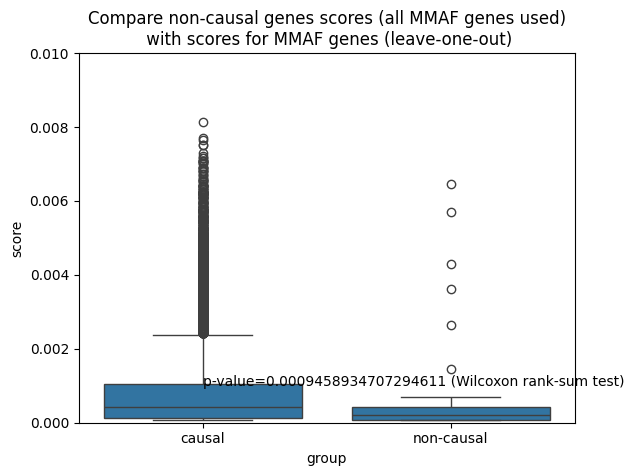

In [21]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze leave-one-out results: newCentrality_v4.py d=10

In [7]:
scores = parse_scores("/home/kubicaj/calc/output/scores_d10.tsv", causal_genes)

In [8]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out_d10/left_out_scores.tsv")

In [9]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.01)

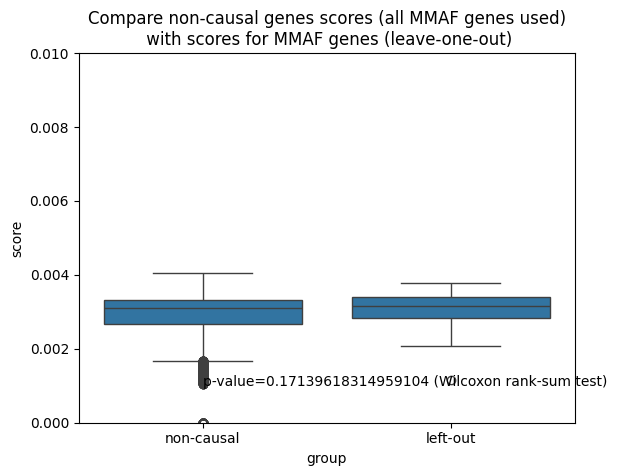

In [10]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze leave-one-out results: pageRankCentrality.py d=5

In [64]:
scores = parse_scores("/home/kubicaj/calc/output/scores_pageRank.tsv", causal_genes)

In [58]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out_pageRank/left_out_scores.tsv")

In [59]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.01)

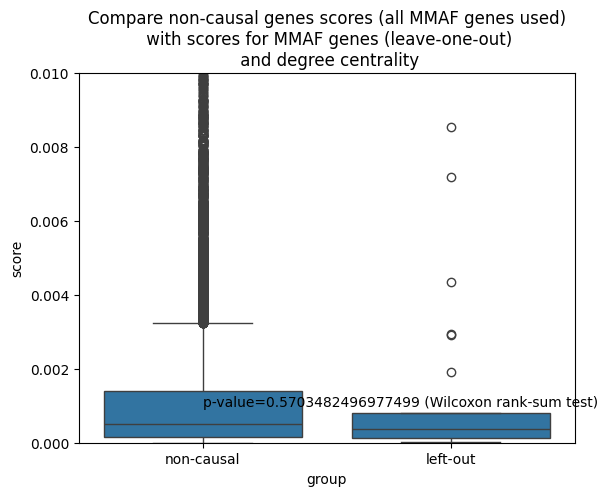

In [60]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze leave-one-out results: pageRankCentrality.py d=10

In [8]:
scores = parse_scores("/home/kubicaj/calc/output/scores_pageRank_d10.tsv", causal_genes)

In [9]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out_pageRank_d10/left_out_scores.tsv")

In [10]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.01)

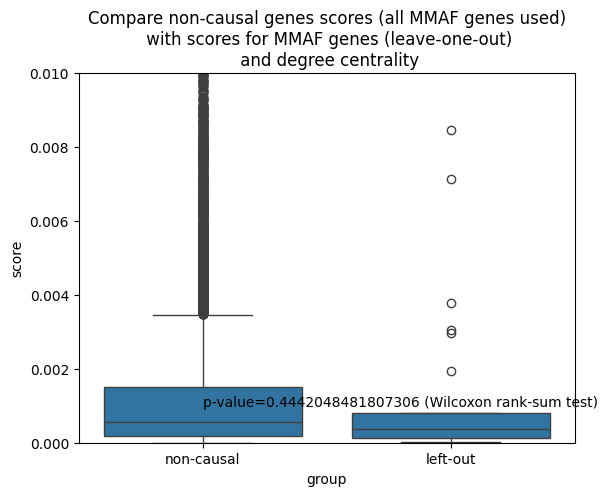

In [11]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.01)

### Analyze canonical centralities

In [25]:
def parse_centrality_scores(scores_file):
    # load scores
    scores_causal = {}
    scores_nonCausal = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 0:
                scores_nonCausal[gene] = float(score)
            else:
                scores_causal[gene] = float(score)
    return scores_causal, scores_nonCausal

In [27]:
def concatenate_centrality_scores(scores_causal, scores_nonCausal):
    df_causal = pandas.DataFrame.from_dict(scores_causal, 
                                       orient='index', 
                                       columns=['score'])
    df_causal['group'] = "causal"

    df_nonCausal = pandas.DataFrame.from_dict(scores_nonCausal, 
                                            orient='index', 
                                            columns=['score'])

    df_nonCausal['group'] = 'non-causal'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_causal, df_nonCausal])

    stat, p_value = ranksums(df_causal['score'].values, df_nonCausal['score'].values)

    return df_compare, p_value

#### Analyze degree centrality

In [26]:
scores_DC_causal, scores_DC_nonCausal = parse_centrality_scores("/home/kubicaj/calc/output/scores_DC.tsv")

In [28]:
df_compare, p_value = concatenate_centrality_scores(scores_DC_causal, scores_DC_nonCausal)

(0.0, 0.01)

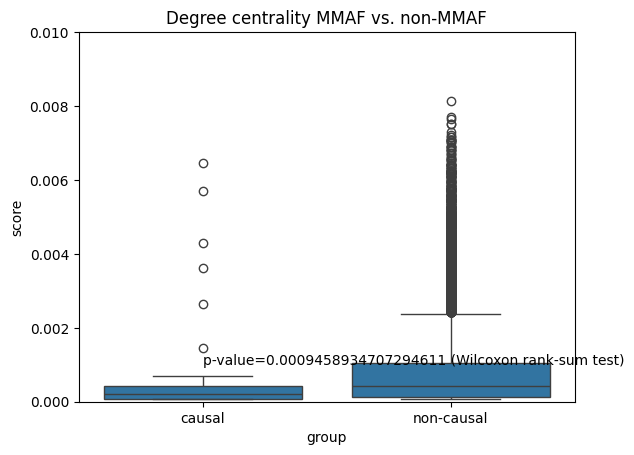

In [29]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Degree centrality MMAF vs. non-MMAF")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze betweenness centrality

In [30]:
scores_BC_causal, scores_BC_nonCausal = parse_centrality_scores("/home/kubicaj/calc/output/scores_BC.tsv")

In [31]:
df_compare, p_value = concatenate_centrality_scores(scores_BC_causal, scores_BC_nonCausal)

(0.0, 0.01)

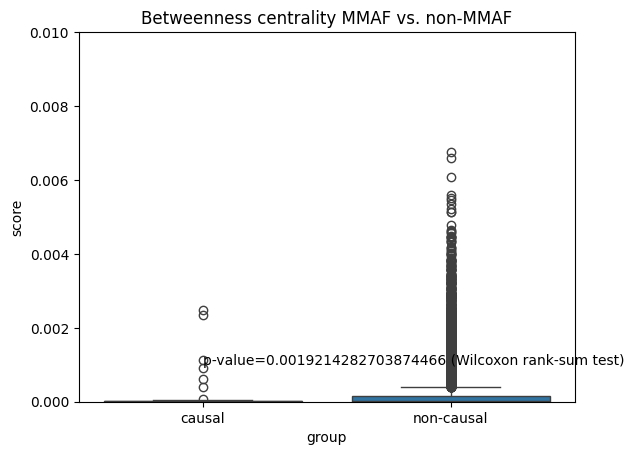

In [32]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Betweenness centrality MMAF vs. non-MMAF")
matplotlib.pyplot.ylim(0, 0.01)

### Top 10 genes newCentrality_v4

In [38]:
scores = parse_scores("/home/kubicaj/calc/output/scores_d10.tsv", causal_genes)

In [39]:
scores_sorted = dict(sorted(scores.items(), key=lambda v: v[1], reverse=True))

In [40]:
# get more info about each node (degree, causal genes at distances)
for n, score in scores_sorted.items():
    scores_sorted[n] = [score, 
                             interactome.degree(n), 
                             causal_genes_at_distance(dict_distances, n, 1), 
                             causal_genes_at_distance(dict_distances, n, 2),
                             causal_genes_at_distance(dict_distances, n, 3),
                             causal_genes_at_distance(dict_distances, n, 4)]

df = pandas.DataFrame.from_dict(scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

In [41]:
df

,score,degree,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4
ENSG00000057704,0.004057,1,0,0,2,5
ENSG00000198298,0.003978,1,0,0,1,7
ENSG00000089639,0.003973,1,0,0,3,12
ENSG00000188408,0.003964,1,0,0,1,8
ENSG00000182791,0.003953,1,0,2,5,17
...,...,...,...,...,...,...
ENSG00000140279,0.000000,1,0,0,0,0
ENSG00000009830,0.000000,1,0,0,0,0
ENSG00000130714,0.000000,1,0,0,0,0
ENSG00000118702,0.000000,1,0,0,0,0
